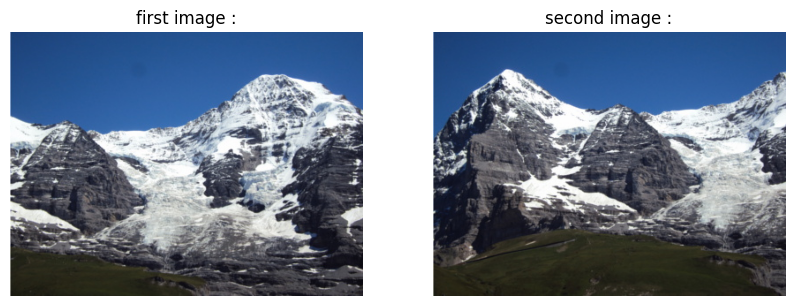

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image = cv2.imread("C:\\Users\\ADMIN\\Downloads\\2Hill.JPG")
img1 = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
img1gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

image2 = cv2.imread("C:\\Users\\ADMIN\\Downloads\\1Hill.JPG")
img2 = cv2.cvtColor(image2,cv2.COLOR_BGR2RGB)
img2gray = cv2.cvtColor(image2,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title("first image :")
plt.axis("OFF")

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title("second image :")
plt.axis("OFF")
plt.show()

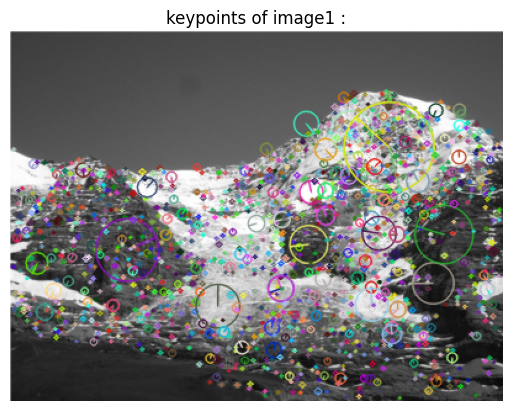

-------------------------------------------------------------------------


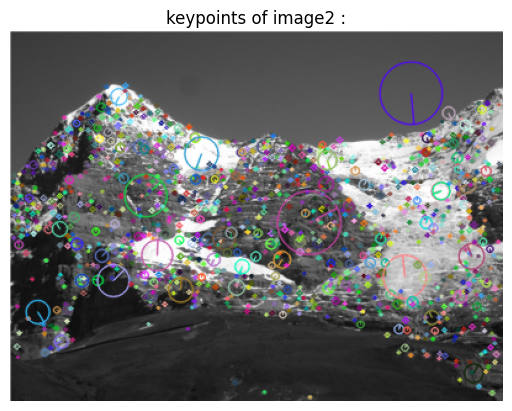

In [14]:
# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints in the image
kp, descrip = sift.detectAndCompute(img1gray, None)
# Draw the keypoints on the image
imgk = cv2.drawKeypoints(img1gray,
                         kp,
                         None,  # Output image
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.imshow(imgk,cmap='gray')
plt.title("keypoints of image1 :")
plt.axis("OFF")
plt.show()

print("-------------------------------------------------------------------------")

# Create SIFT detector
sift = cv2.SIFT_create()

# Detect keypoints in the image
kp2, descrip2 = sift.detectAndCompute(img2gray, None)
# Draw the keypoints on the image
imgk2 = cv2.drawKeypoints(img2gray,
                         kp2,
                         None,  # Output image
                         flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure()
plt.imshow(imgk2,cmap='gray')
plt.title("keypoints of image2 :")
plt.axis("OFF")
plt.show()

In [15]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(descrip,descrip2, k=2)
MIN_MATCH_COUNT = 50

good = []
for m,n in matches:
    if m.distance < 0.282*n.distance:
        good.append(m)

print(len(good))

src_pts = []
dst_pts = []
for match in good:
    src_pt = kp[match.queryIdx].pt
    dst_pt = kp2[match.trainIdx].pt
    src_pts.append(src_pt)
    dst_pts.append(dst_pt)

src_pts = np.float32(src_pts).reshape(-1, 2)
dst_pts = np.float32(dst_pts).reshape(-1, 2)

364


In [16]:
import random
def find_homography_matrix(src_pts,dst_pts,ransac_threshold):
    n = len(src_pts)
    i = random.randint(0,n-1)
    j = random.randint(0,n-1)
    k = random.randint(0,n-1)
    m = random.randint(0,n-1)
    if(i != j and i != k and i != m and j != k and j != m and k != m):
        points = []
        flattened1 = list(src_pts[i]) + list(dst_pts[i])
        flattened2 = list(src_pts[j]) + list(dst_pts[j])
        flattened3 = list(src_pts[k]) + list(dst_pts[k])
        flattened4 = list(src_pts[m]) + list(dst_pts[m])
        points.append(flattened1)
        points.append(flattened2)
        points.append(flattened3)
        points.append(flattened4)
        #print(points)
        A = [[0] * 9 for _ in range(9)]
        for q in range(0,8,2):
            for z in range(9):
                if(z == 0):
                    A[q][z] = -points[q//2][0]
                elif(z == 1):
                    A[q][z] = -points[q//2][1]
                elif(z == 2):
                    A[q][z] = -1
                elif(z == 3):
                    A[q+1][z] = -points[q//2][0]
                elif(z == 4):
                    A[q+1][z] = -points[q//2][1]
                elif(z == 5):
                    A[q+1][z] = -1
                elif(z == 6):
                    A[q][z] = points[q//2][0] * points[q//2][2] 
                    A[q+1][z] = points[q//2][0] * points[q//2][3] 
                elif(z == 7):
                    A[q][z] = points[q//2][1] * points[q//2][2] 
                    A[q+1][z] = points[q//2][1] * points[q//2][3] 
                elif(z == 8):
                    A[q][z] = points[q//2][2]
                    A[q+1][z] = points[q//2][3]
        A[8][8] = 1
        """for row in A:
            r = [float(x) for x in row]
            print([x for x in r])"""
        U, S, V = np.linalg.svd(A)
        h = V[-1, :]
        H = h.reshape(3, 3)
        H = H / H[2,2]
        
        """print("Homography Matrix H:")
        for row in H:
            print(row)"""
        loss = 0
        for i in range(n):
            x = list(src_pts[i])
            x_dash = list(dst_pts[i])
            t = np.dot(H,[x[0],x[1],1])
            t = t / t[2]
            loss = loss + np.abs(x_dash[0] - t[0])
            loss = loss + np.abs(x_dash[1] - t[1])
        return loss / n , H

    else:
        x = 0

        
for i in range(100):
    loss, H = find_homography_matrix(src_pts,dst_pts,5)
    if(loss <= 0.9):
        break
print(loss)
print("Homography Matrix H:")
for row in H:
    print(row)
h,w,c = img1.shape
pts = np.float32([ [0,0],[w-1,0],[w-1,h-1],[0,h-1]]).reshape(-1,1,2)
dst = []
for u in range(4):
    f = pts[u]
    x = [f[0][0],f[0][1],1]
    t = np.dot(H,x)
    t = t/t[2]    
    dst.append(t)
print(dst)

0.26789583888884044
Homography Matrix H:
[8.75911306e-01 5.81138995e-02 1.44926524e+02]
[ -0.09496122   0.97226758 -11.09383707]
[-3.32358790e-04  4.44514746e-05  1.00000000e+00]
[array([144.92652357, -11.09383707,   1.        ]), array([570.00402844, -56.47220924,   1.        ]), array([581.13195168, 274.47505044,   1.        ]), array([160.17371216, 275.94656561,   1.        ])]


In [17]:
print(len(good))

364


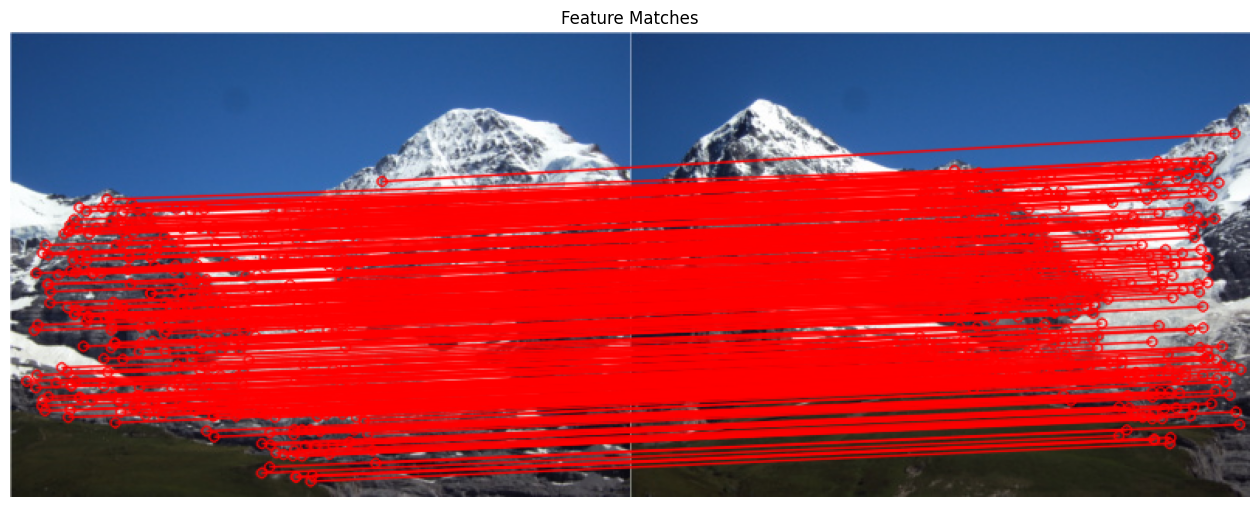

In [18]:
draw_params = dict(matchColor = (255,0,0),
                   singlePointColor = None,
                   matchesMask = [1]*len(good),
                   flags = 2)

img_matches = cv2.drawMatches(
    img1, kp, img2, kp2, good, None, **draw_params
)

plt.figure(figsize=(16, 8))
plt.imshow(img_matches)
plt.title("Feature Matches")
plt.axis("off")
plt.show()

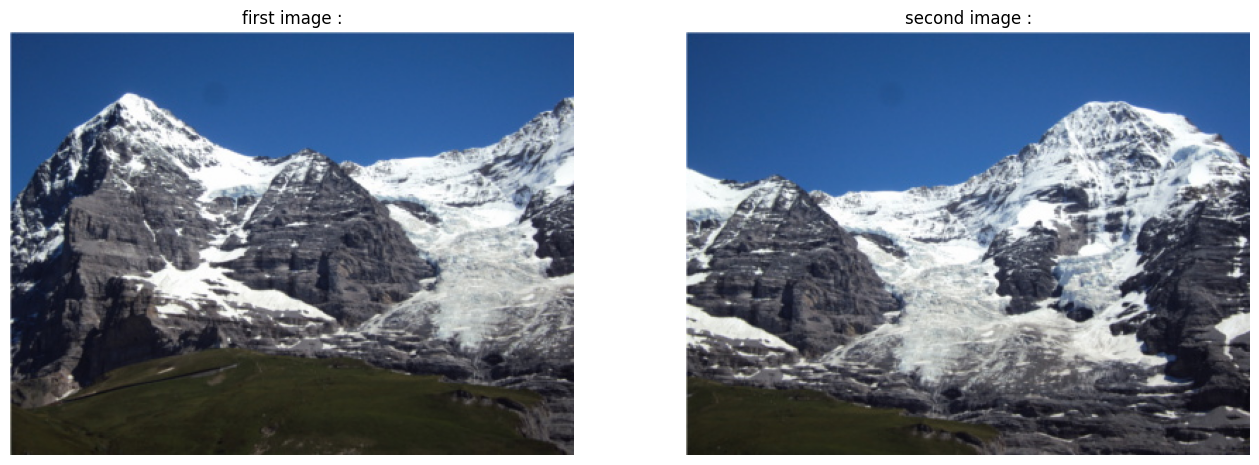

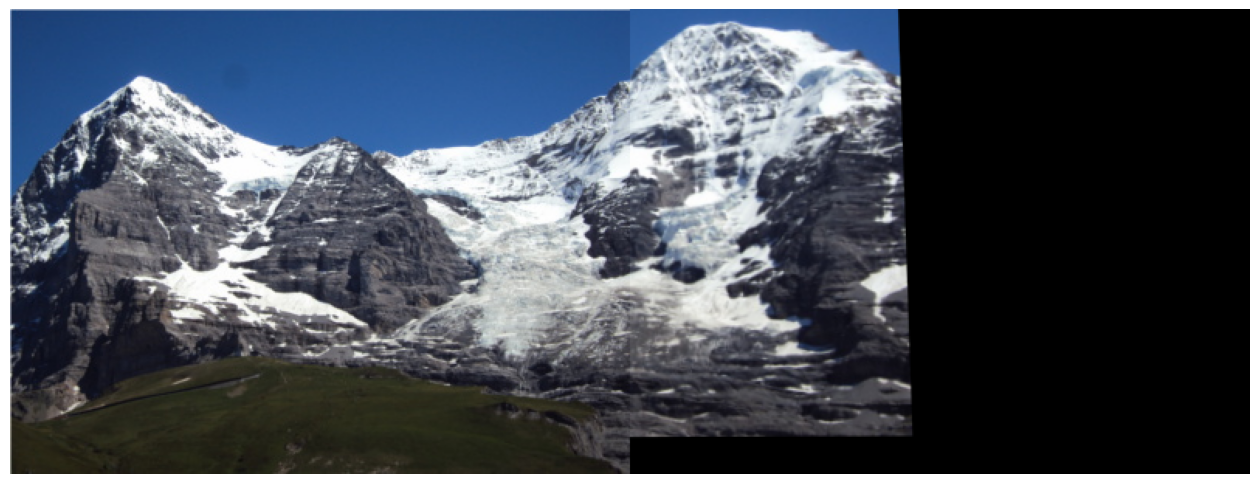

In [19]:
plt.figure(figsize=(16, 8))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(img2)
plt.title("first image :")
plt.axis("OFF")

plt.subplot(1, 2, 2)
plt.imshow(img1)
plt.title("second image :")
plt.axis("OFF")
plt.show()

dst = cv2.warpPerspective(img1,H,(img2.shape[1] + img1.shape[1], img2.shape[0]))
plt.figure(figsize=(16, 8))
dst[0:img2.shape[0], 0:img2.shape[1]] = img2
plt.imshow(dst)
plt.axis("OFF")
plt.show()

In [20]:
def warp_image(img, H):
    h, w = img.shape[:2]
    
    red_channel = np.zeros((h, w * 2), dtype=np.float32)
    green_channel = np.zeros((h, w * 2), dtype=np.float32)
    blue_channel = np.zeros((h, w * 2), dtype=np.float32)
    counter_matrix = np.zeros((h, w * 2), dtype=np.int32)
    
    for i in range(h):
        for j in range(w):
            point = np.array([j, i, 1])
            t = np.dot(H, point)
            t = t / t[2]
            
            x_new, y_new = int(t[0]), int(t[1])
            
            if 0 <= x_new < red_channel.shape[1] and 0 <= y_new < h:
                red_channel[y_new, x_new] = red_channel[y_new, x_new] + img[i, j, 0]  
                green_channel[y_new, x_new] = green_channel[y_new, x_new] + img[i, j, 1] 
                blue_channel[y_new, x_new] = blue_channel[y_new, x_new] + img[i, j, 2]
                counter_matrix[y_new, x_new] = counter_matrix[y_new, x_new]  + 1
    
    counter_matrix[counter_matrix == 0] = 1
    red_channel = red_channel / counter_matrix
    green_channel = green_channel / counter_matrix
    blue_channel = blue_channel / counter_matrix

    result_img = np.stack((red_channel, green_channel, blue_channel), axis=2)
    result_img = np.clip(result_img, 0, 255).astype(np.uint8)

    return result_img

result_img = warp_image(img1, H)


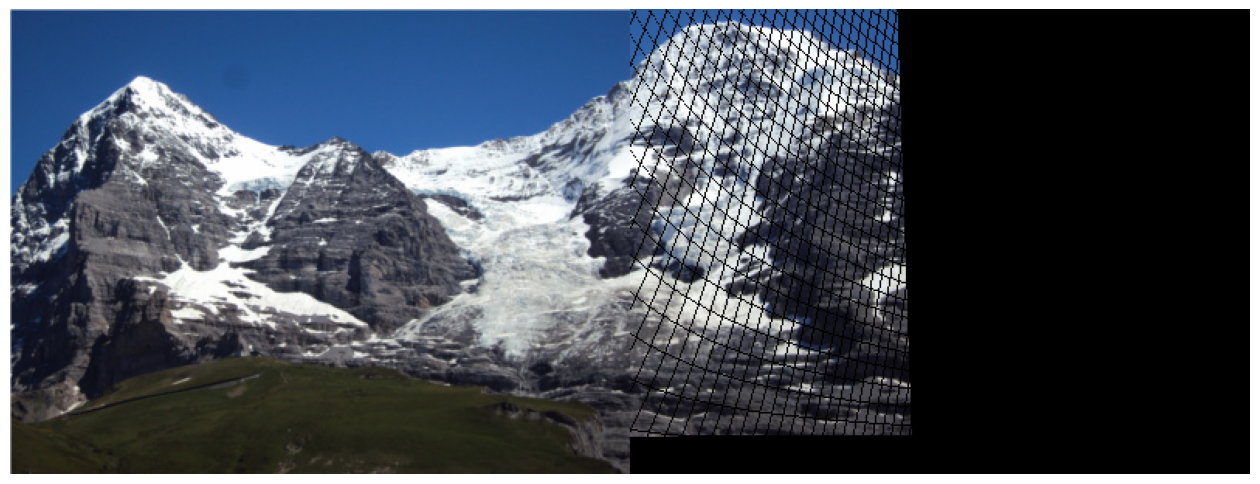

In [21]:
h, w = img2.shape[:2]
result_img[0:h, 0:w] = img2

# Display the final image
plt.figure(figsize=(16, 8))
plt.imshow(result_img)
plt.axis("off")
plt.show()

In [22]:
import numpy as np
import math

def inverse_warp_image(result_img, H_inv, img1):
    h, w = result_img.shape[:2]
    
    red_channel = np.zeros((h, w), dtype=np.float32)
    green_channel = np.zeros((h, w), dtype=np.float32)
    blue_channel = np.zeros((h, w), dtype=np.float32)
    
    for i in range(h):
        for j in range(w):
            point = np.array([j, i, 1])
            x = np.dot(H_inv, point)
            x = x / x[2]
            
            x0, y0 = math.floor(x[0]), math.floor(x[1])
            x1, y1 = math.ceil(x[0]), math.ceil(x[1])
            valid_count = 0
            
            if (0 <= x0 < img1.shape[1] and 0 <= y0 < img1.shape[0]):
                red_channel[i, j] = red_channel[i, j] + img1[y0, x0, 0]
                green_channel[i, j] = green_channel[i, j] + img1[y0, x0, 1]
                blue_channel[i, j] = blue_channel[i, j] + img1[y0, x0, 2]
                valid_count += 1
            
            if (0 <= x1 < img1.shape[1] and 0 <= y0 < img1.shape[0]):
                red_channel[i, j] = red_channel[i, j] + img1[y0, x1, 0]
                green_channel[i, j] = green_channel[i, j] + img1[y0, x1, 1]
                blue_channel[i, j] = blue_channel[i, j] + img1[y0, x1, 2]
                valid_count += 1
            
            if (0 <= x0 < img1.shape[1] and 0 <= y1 < img1.shape[0]):
                red_channel[i, j] = red_channel[i, j] + img1[y1, x0, 0]
                green_channel[i, j] = green_channel[i, j] + img1[y1, x0, 1]
                blue_channel[i, j] = blue_channel[i, j] + img1[y1, x0, 2]
                valid_count += 1
            
            if (0 <= x1 < img1.shape[1] and 0 <= y1 < img1.shape[0]):
                red_channel[i, j] = red_channel[i, j] + img1[y1, x1, 0]
                green_channel[i, j] = green_channel[i, j] + img1[y1, x1, 1]
                blue_channel[i, j] = blue_channel[i, j] + img1[y1, x1, 2]
                valid_count += 1
            
            if (valid_count > 0):
                red_channel[i, j] = red_channel[i, j] / valid_count
                green_channel[i, j] = green_channel[i, j] / valid_count
                blue_channel[i, j] = blue_channel[i, j] / valid_count

    result_img = np.stack((red_channel, green_channel, blue_channel), axis=2)
    result_img = np.clip(result_img, 0, 255).astype(np.uint8)

    return result_img

result_img2 = inverse_warp_image(result_img, np.linalg.inv(H), img1)

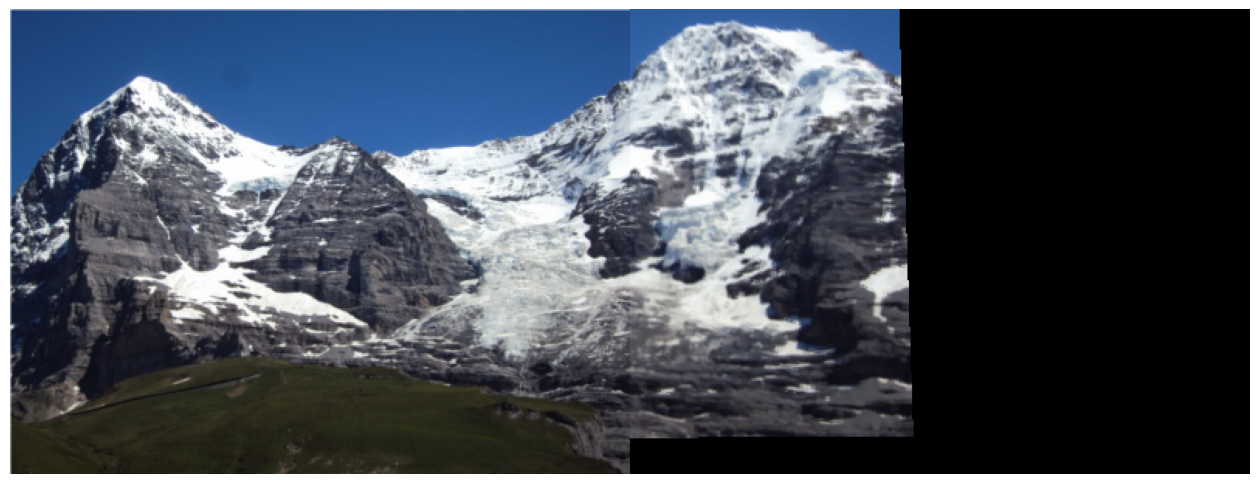

In [23]:
h, w = img2.shape[:2]
result_img2[0:h, 0:w] = img2

# Display the final image
plt.figure(figsize=(16, 8))
plt.imshow(result_img2)
plt.axis("off")
plt.show()